<a href="https://colab.research.google.com/github/amya-singhal/FinalProjectCS484/blob/main/FinalProject_Semisupervised_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 5: Semi-supervised image classification**


# Project Collaborators:

*   Amya Singhal (20930784) : amya.singhal@uwaterloo.ca
*   Shruti Srivatsan (21000026) : s3srivat@uwaterloo.ca

# Abstract

The project is a deep dive into semi-supervised learning applied specifically to image classification tasks. The primary focus is around addressing scenarios where labeled data is limited, exploring the impact of varying the quantity of labeled images (represented by 'M' out of total 'N' images), and evaluating the effectiveness of weakly supervised training strategy leveraging both labeled and unlabeled data.


The project employs two distinct machine learning models, namely Convolutional Neural Networks (CNNs) and Residual Networks (ResNets), to investigate and compare their performance in a semi-supervised setting. Leveraging the CIFAR-10 dataset, the project ignores labels on a subset of training examples to simulate scenarios with limited labeled data.

Motivation:

The motivation behind this exploration is multifaceted. Firstly, it addresses a real-world challenge in machine learning (learning from limited labeled data) , an issue faced in various industries due to resource constraints. Secondly, it underscores the significance of leveraging unlabeled data, which is often abundant but underutilized, showcasing the potential of semi-supervised learning to extract valuable insights from incomplete labeled datasets.

We aimed to incorporate explainable AI into our project, leveraging the Grad-CAM technique learned in our classroom. By implementing CAM, we visualized and interpreted our model's decision-making process, highlighting crucial image regions impacting their predictions. Additionally, we used cluster analysis, and prediction display techniques to augment the evaluation, offering comprehensive insights into model behavior and performance.


# Team Members and Contributions

*   ***Amya Singhal (20930784) : amya.singhal@uwaterloo.ca***
*   Contributions: Preprocessing, Augmentation, CNN Model, Validation, GradCAM, Report

*   ***Shruti Srivatsan (21000026) : s3srivat@uwaterloo.ca***
*   Contributions: EDA, Training, ResNet Model, Cluster Visualizations, Graphs, Report






# Code Libraries

The imports have the following significance:

'torch' and 'torch.nn' is imported to access Pytorch's neural network module(nn) which contains classes and functions to define NN architectures

'torch.optim' provides various optimization algortihmslike SGD, Adam which is essential to update the paramteres during training.

'matplotlib.pyplot as plt' is used for plotting graphs and visualise the performance of our models on the dataset.

'numpy as np' is imported for numerical computing purposes.

'KMeans from sklearn.cluster' is imported for the unsupervised learning training helpful for clustering data.

'metrics from sklearn' allows us to evaluate clustering performance.

'tensorflow.keras' provides us with the high-level building blocks for our neural network.


In [ ]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Input
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import cv2

# Loading Images

This process was started out by normalization that is converting the pixel values from (0, 255) to (0, 1) which standardizes the input data. This helps in preventing numerical instabiolities and ensures uniformity across features leading to faster convergence during training. After this, we converted the categorical labels to binary matrix format which means the true label is represented by a vector where 1 is for the true class index and 0s elsewhere.


In [ ]:
# Loads the dataset as train and test images
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# normalizing the pixels in the data to make them suitable for model training
# originally: value between [0, 255] for all the three color channels
# after normalization: floating point numbers between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
# num_classes is the total number of labels in the dataset
num_classes = 10
# changing the labels to one-hot encoding because in classification tasks it is preferred
# binary matrix representation where the true class is set to 1 and all the rest are set to 0
train_labels_ = to_categorical(train_labels, num_classes)
test_labels_ = to_categorical(test_labels, num_classes)

170498071/170498071 [==============================] - 13s 0us/step


# EDA

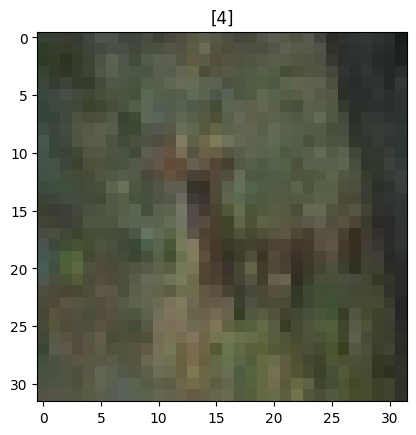

In [ ]:
plt.imshow(train_images[10])
plt.title(train_labels[10])
plt.show()


In [ ]:
print(np.unique(train_labels, return_counts=True))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


# Data Augmentation

This step helps us in creating variations of existing images, effectively increasing the diversity of the dataset. The main reason we did this step is to prevent overfitting and help our models generalize better for unseen and new data by learning invariant features.


In [ ]:
data_aug = ImageDataGenerator(
    # rotates original image -15 and +15 degrees
    rotation_range=15,
    # horizontally shifting by upto 10% of original width
    width_shift_range=0.1,
    # vertically shifted by upto 10% of original height
    height_shift_range=0.1,
    # flipping the image horizontally
    horizontal_flip=True,
)

data_aug.fit(train_images)

# Training

Weakly supervised training is carried out with a combination of labeled and unlabeled data. KMeans clustering is applied and M values of 7000, 5000 and 3000 are used to check the variation of M values with the model performance.

In [ ]:
def weakly_supervised_training(model, labeled_images, labeled_labels, unlabeled_images, num_clusters=10, epochs=10):
    """
    Perform weakly supervised training using a combination of labeled and unlabeled data.

    Parameters:
    - model (tf.keras.Model): The neural network model to be trained.
    - labeled_images (numpy.ndarray): Labeled images for supervised training.
    - labeled_labels (numpy.ndarray): Corresponding labels for the labeled images.
    - unlabeled_images (numpy.ndarray): Unlabeled images for pseudo-label generation.
    - num_clusters (int, optional): Number of clusters for KMeans algorithm. Default is 10.
    - epochs (int, optional): Number of training epochs. Default is 10.

    Returns:
    None
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Supervised training on labeled data
        model.fit(labeled_images, labeled_labels, epochs=1, batch_size=32, verbose=1)

        # Extract features from the second-to-last layer of the model
        features_model = Model(inputs=model.input, outputs=model.layers[-2].output)
        labeled_features = features_model.predict(labeled_images)
        unlabeled_features = features_model.predict(unlabeled_images)

        # Apply KMeans clustering on unlabeled features
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(unlabeled_features)
        pseudo_labels = kmeans.predict(unlabeled_features)
        pseudo_labels = to_categorical(pseudo_labels, num_clusters)

        # Combine labeled and pseudo-labeled data
        combined_images = np.concatenate([labeled_images, unlabeled_images], axis=0)
        combined_labels = np.concatenate([labeled_labels, pseudo_labels], axis=0)

        # Weakly supervised training on combined data
        model.fit(combined_images, combined_labels, epochs=1, batch_size=32, verbose=1)
        # Evaluate clustering metrics on unlabeled data
        silhouette_avg, ari, nmi = evaluate_clustering_metrics(unlabeled_features, pseudo_labels,kmeans)
        print(f"Silhouette Score: {silhouette_avg}")
        print(f"Adjusted Rand Index (ARI): {ari}")
        print(f"Normalized Mutual Information (NMI): {nmi}")

        # Visualize clusters
        visualize_clusters(unlabeled_features, pseudo_labels.argmax(axis=1), kmeans.labels_,
                           title=f'Cluster Visualization - Epoch {epoch + 1}')

# Cluster Evaluation

Clusters are visualized and the cluster metrics are evaluated

In [ ]:
def evaluate_clustering_metrics(features, predicted_labels, kmeans):
    """
    Evaluate clustering metrics for a given clustering result.

    Parameters:
    - features (numpy.ndarray): The input features used for clustering.
    - predicted_labels (numpy.ndarray): Predicted cluster labels.
    - kmeans (sklearn.cluster.KMeans): KMeans clustering model.

    Returns:
    - silhouette_avg (float): Average silhouette score.
    - ari (float): Adjusted Rand Index.
    - nmi (float): Normalized Mutual Information.
    """
    predicted_labels = np.argmax(predicted_labels, axis=1)
    true_labels = kmeans.labels_
    silhouette_avg = silhouette_score(features, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return silhouette_avg, ari, nmi


def visualize_clusters(features, predicted_labels, true_labels, title='Cluster Visualization'):
    """
    Visualize clusters using a scatter plot.

    Parameters:
    - features (numpy.ndarray): The input features used for clustering.
    - predicted_labels (numpy.ndarray): Predicted cluster labels.
    - true_labels (numpy.ndarray): True cluster labels.
    - title (str): Title for the plot (default is 'Cluster Visualization').

    Returns:
    None
    """
    plt.scatter(features[:, 0], features[:, 1], c=true_labels, cmap='viridis', marker='o', label='True Labels')
    plt.scatter(features[:, 0], features[:, 1], c=predicted_labels, cmap='viridis', marker='x', label='Predicted Labels')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()


# Prediction Method

“display_predictions” method help us in showcasing podel’s predicted labels alongside the true labels for the selected image. In the pdf version, we have plotted two images such that one of the images predicted label matches the true label and for the other image it is wrong. It is a quick assessment of the model’s accuracy, and provides clear representation of the model’s performance on individual samples.


In [ ]:
def display_predictions(model, images, labels):
    """
    Display predictions made by selected model on a set of images alongside their true labels.

    Args:
    - model: machine learning model to make predictions
    - images: array of images to make predictions on
    - labels: true labels corresponding to the selected images

    Returns:
    - None
    """
    plt.figure(figsize=(10, 5))

    for i in range(2):
        # reshaping image to enter into the model
        image = images[i].reshape(1, 32, 32, 3)
        # model's prediction
        prediction = model.predict(image)
        # finding the max probability index to get the predicted label/class
        predicted_class = np.argmax(prediction)
        # extracting true label for this image
        true_label = labels[i]

        plt.subplot(1, 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True Class: {true_label}\nPredicted Class: {predicted_class}\nCorrect: {true_label == predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Grad-cam methods

Gradient-weighted Class activation mapping is a powerful visualization technique which provides insights into which regions of the image are crucial for influencing the predictions done by neural network model.
It generates heatmaps highlights the region highly influencing the model’s decision-making process. This helps us have more confidence and trust in the model’s predictions.


In [ ]:
def get_grad_cam(model, image, last_layer_name, eps=1e-8):

    """
    Compute Grad-CAM (Gradient-weighted Class Activation Mapping) for a given image and model.

    Args:
    - model: selected model to be used for Grad-CAM
    - image: input image for which Grad-CAM needs to be computed
    - last_layer_name: name of the last convolutional layer in the model.
    - eps: epsilon value to avoid division by zero.

    Returns:
    - Heatmap obtained from Grad-CAM computation.
    """

    # get the last convolutional layer of the mode using th last_layer__name
    last_layer = model.get_layer(last_layer_name)

    # creating the grad-cam model which is cut-off from the main model provided as input
    grad_model = Model(
			inputs=[model.inputs],
			outputs=[last_layer.output,
				model.output])

    # computing gradients for image
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (conv_outputs, predictions) = grad_model(inputs)
      # loss for the specific class index
      loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)

    # generating guided weights and computing weights
    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # resize heatmap w and h to match the width and height of the original image
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalizing the heatmap values between 0 and 1
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(image_bgr, cam, threshold, emphasize=False):
    """
    Generate a superimposed image by overlaying the heatmap on the original image.

    Args:
    - image_bgr: The original image in BGR format (OpenCV format)
    - cam: The heatmap obtained from get_grad_cam
    - threshold: Threshold value for sigmoid function if emphasis is enabled
    - emphasize: Boolean flag to emphasize the heatmap.

    Returns:
    - Superimposed image with the overlay of the heatmap.
    """

    # resizing heatmap
    heatmap = cv2.resize(cam, (image_bgr.shape[1], image_bgr.shape[0]))

    # emphasizing heatmap using sigmoid
    if emphasize:
        heatmap = sigmoid(heatmap, 50, threshold, 1)
    # scalling upto 0-255 range from 0-1
    heatmap = np.uint8(255 * heatmap)
    # applying color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlaying the heatmap on top of the original image
    # intensity factor
    intensityFactor = .8
    overlay_image = heatmap * intensityFactor + image_bgr
    overlay_image = np.minimum(overlay_image, 255.0).astype(np.uint8)  # scale 0 to 255
    overlay_image_rgb = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)

    return overlay_image_rgb

# Model 1: CNN

Model Architecture: The model here defines a simple CNN architecture for image classification, starting with an input layer followed by four convolutional layers, each with increasing filter sizes (32, 64, 128, and 256). Batch normalization and rectified linear unit (ReLU) activation functions enhance training stability and introduce non-linearity within the model. Max-pooling layers downsample the spatial dimensions and the final flattened feature maps connect to a dense layer with softmax activation for classifying images into specified categories.

---


 Why CNN? CNN’s offer balance between model complexity and computational
efficiency which can be useful. In semi-supervised learning, where labeled data is limite, CNN’s ability to automatically extract and learn features from unlabelled data is very useful.

In [ ]:
def simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    Simple Convolutional Neural Network (CNN) architecture for image classification.

    Args:
    - input_shape: shape of input images (width, height, channels)
    - num_classes: number of classes for classification

    Returns:
    - model representing the CNN architecture
    """

    # input layer for model
    model_input = Input(shape=input_shape)

    # Convolutional Layer 1
    x = Conv2D(32, (3, 3), padding='same')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Layer 4
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # flattening the feature maps to get dense layers
    x = Flatten()(x)

    # output layer
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=output)
    return model

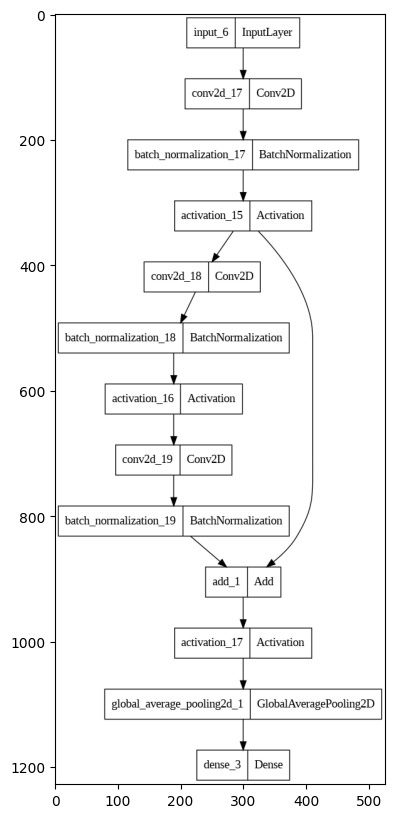

In [ ]:
model = build_resnet()
plot_model(model, to_file='model_cnn.png', show_shapes=False, show_layer_names=True)
plt.figure(figsize=(10, 10))
img = plt.imread('model_cnn.png')
plt.imshow(img)
plt.show()

In [ ]:
def visualize_model(model):
    layer_names = [layer.name for layer in model.layers]

    fig, axs = plt.subplots(1, len(model.layers), figsize=(20, 3))

    for i, layer in enumerate(model.layers):
        axs[i].imshow([[1]], cmap='gray', aspect='auto')
        axs[i].axis('off')

    plt.show()

## Building Model

In [ ]:
cnn_model = simple_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#cnn_model = simple_cnn()
#cnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

## Training with 3 sets of values

Epoch 1/3
1344/1344 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 1.1118 - accuracy: 0.6369
Silhouette Score: 0.07144374400377274
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


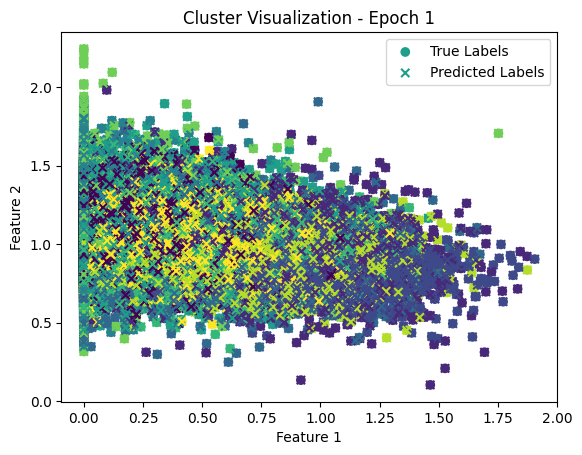

Epoch 2/3
1344/1344 [==============================] - 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 10s 6ms/step - loss: 1.0951 - accuracy: 0.6440
Silhouette Score: 0.06373896449804306
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


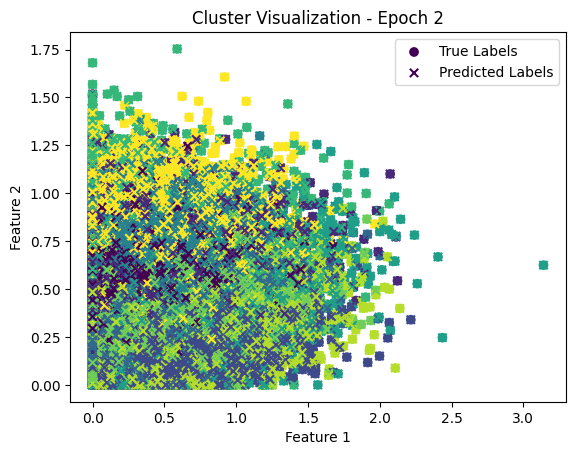

Epoch 3/3
1344/1344 [==============================] - 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 1.0564 - accuracy: 0.6481
Silhouette Score: 0.06051960587501526
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


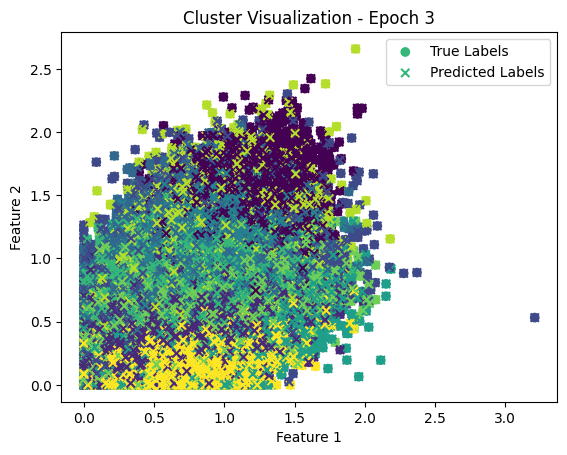

Epoch 1/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 10s 6ms/step - loss: 0.8666 - accuracy: 0.7146
Silhouette Score: 0.06971300393342972
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


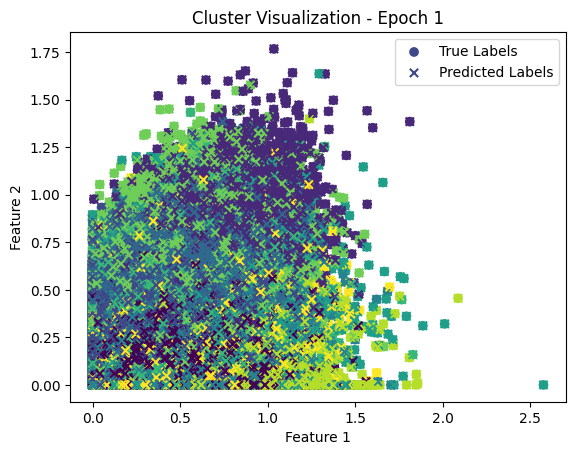

Epoch 2/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 10s 7ms/step - loss: 0.8990 - accuracy: 0.7146
Silhouette Score: 0.07095525413751602
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


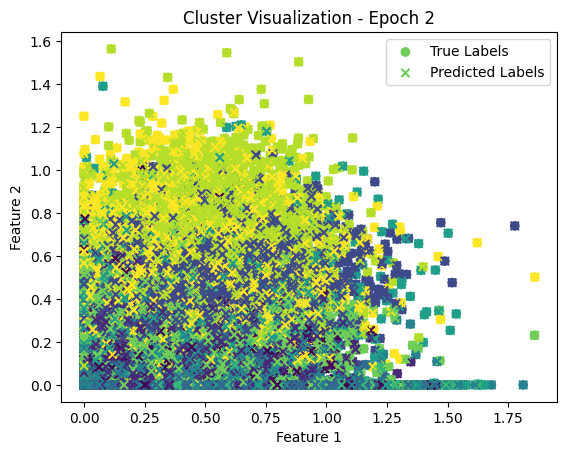

Epoch 3/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 10s 6ms/step - loss: 0.8600 - accuracy: 0.7181
Silhouette Score: 0.06195089966058731
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


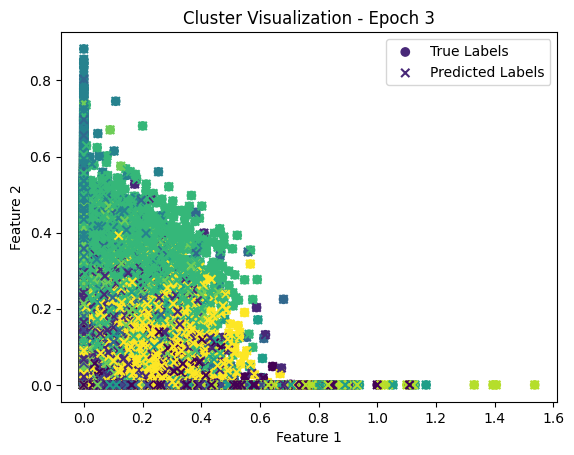

Epoch 1/3
1469/1469 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 10s 7ms/step - loss: 0.7565 - accuracy: 0.7507
Silhouette Score: 0.06194751337170601
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


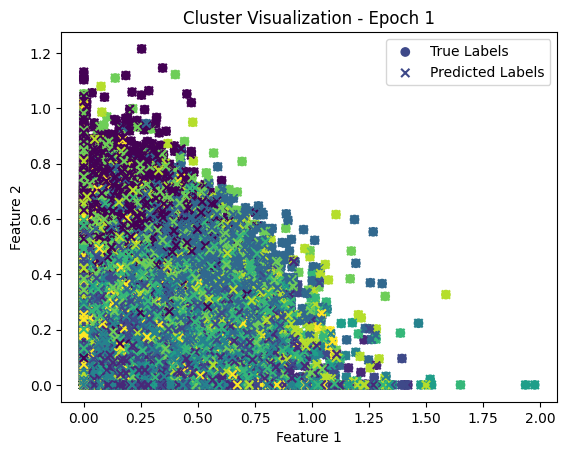

Epoch 2/3
1469/1469 [==============================] - 4s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 11s 7ms/step - loss: 0.7950 - accuracy: 0.7366
Silhouette Score: 0.059567082673311234
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


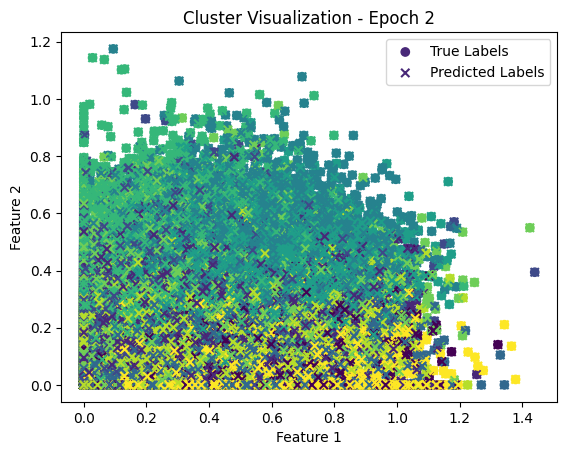

Epoch 3/3
1469/1469 [==============================] - 4s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 11s 7ms/step - loss: 0.7404 - accuracy: 0.7585
Silhouette Score: 0.060356199741363525
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


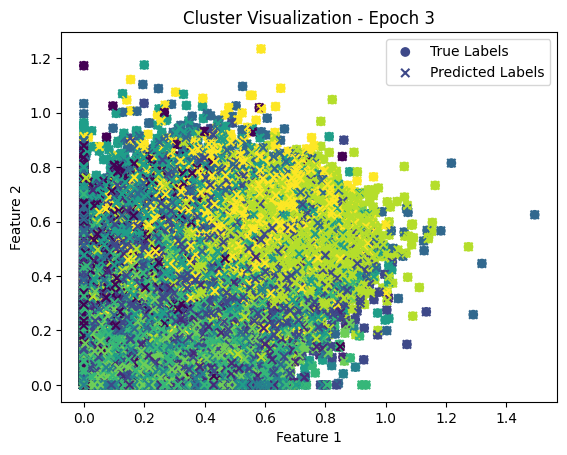

In [ ]:
M_values = [7000, 5000, 3000]
for M in M_values:
    labeled_images = train_images[:M]
    labeled_labels = train_labels_[:M]
    unlabeled_images = train_images[M:]
    cnn_model.set_weights(cnn_model.get_weights())
    weakly_supervised_training(cnn_model, labeled_images, labeled_labels, unlabeled_images, num_clusters=num_classes, epochs=3)

## Prediction for CNN

1/1 [==============================] - 0s 27ms/step


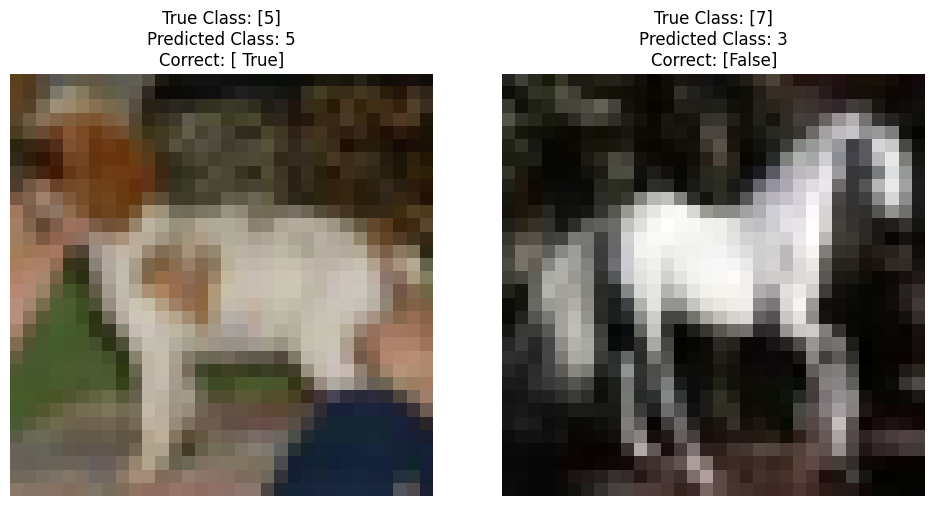

In [ ]:
display_predictions(cnn_model, test_images[12:14], test_labels[12:14])

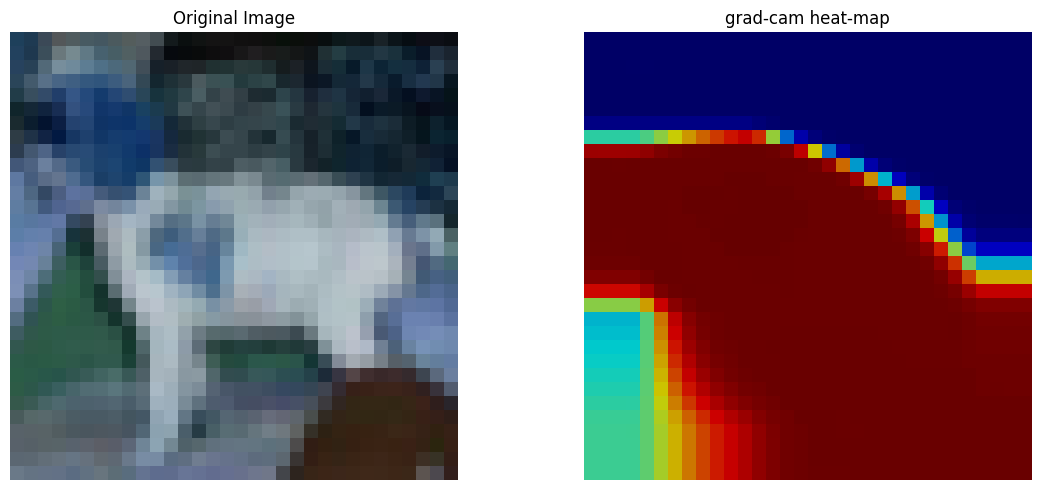

In [ ]:
img = test_images[12]
grad_cam= get_grad_cam(cnn_model,np.expand_dims(img, axis=0), 'conv2d_3')
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('grad-cam heat-map')
plt.tight_layout()

# Model 2: ResNet

Model Architecture: The resnet block consists of two convolutional layers with batch normalization and rectified linear unit (ReLU) activation functions. The output from the second convolutional layer is added to the input tensor, creating a residual connection. The build_resnet function assembles a simple ResNet model based on the defined residual blocks. The model starts with a large convolutional layer for initial feature extraction, followed by a series of residual blocks. Global average pooling is applied to reduce spatial dimensions, and a dense layer with softmax activation produces the final classification output.


---

Why ResNet?
ResNet introduces skip connections/ residual connections, which help in addressing the gradient problem in deeper networks. In semi-supervised scenario, the network could benefit with a more complex architecture. Resnet can prove to be advantageous.


In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    """
    Creates a basic residual block for a ResNet architecture.

    Parameters:
    - x (tf.Tensor): Input tensor.
    - filters (int): Number of filters in the Conv2D layers.
    - kernel_size (int, optional): Size of the convolutional kernel. Default is 3.
    - stride (int, optional): Stride of the convolutional layers. Default is 1.

    Returns:
    - tf.Tensor: Output tensor of the residual block.
    """
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    y = Add()([x, y])
    y = Activation('relu')(y)
    return y

def build_resnet(input_shape=(32, 32, 3), num_classes=10):
    """
    Builds a simple ResNet model with a specified input shape and number of classes.

    Parameters:
    - input_shape (tuple, optional): Shape of the input tensor. Default is (32, 32, 3).
    - num_classes (int, optional): Number of output classes. Default is 10.

    Returns:
    - tf.keras.Model: ResNet model.
    """
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = resnet_block(x, 64)
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


## Building Model

In [ ]:
resnet_model = build_resnet()
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training

Epoch 1/3
1344/1344 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 1.2948 - accuracy: 0.5974
Silhouette Score: 0.1758386790752411
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


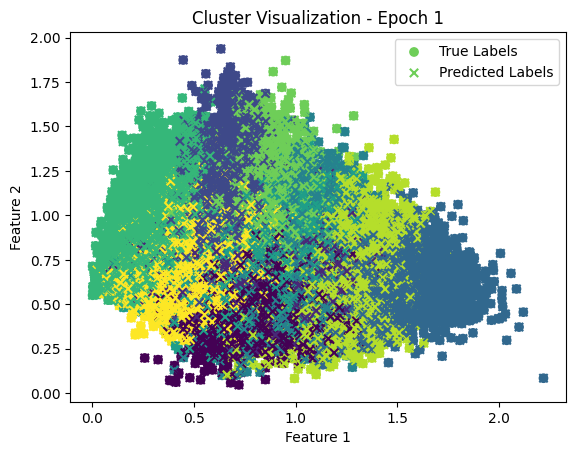

Epoch 2/3
1344/1344 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 5ms/step - loss: 1.1978 - accuracy: 0.6288
Silhouette Score: 0.16161635518074036
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


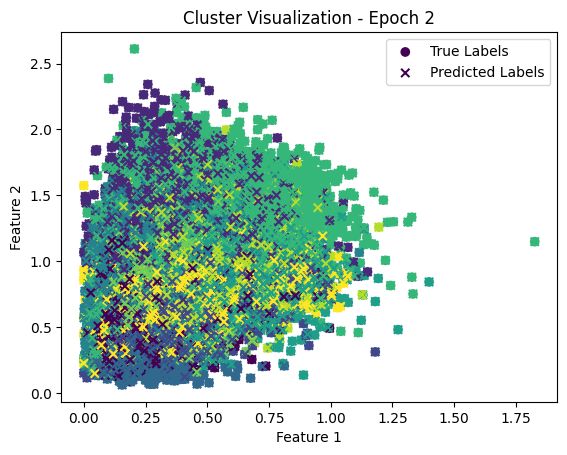

Epoch 3/3
1344/1344 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 1.2411 - accuracy: 0.6125
Silhouette Score: 0.15988793969154358
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


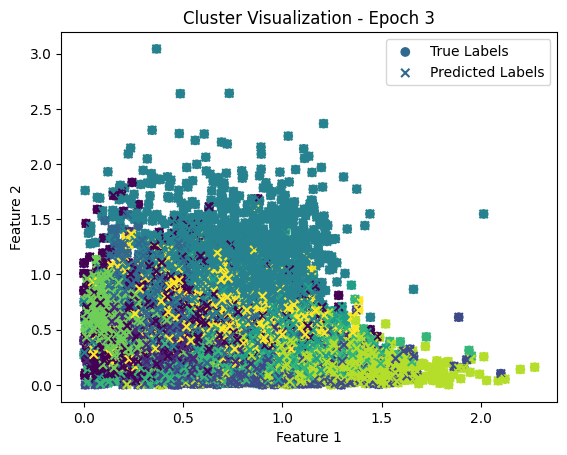

Epoch 1/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 8s 5ms/step - loss: 1.1592 - accuracy: 0.6422
Silhouette Score: 0.1539376825094223
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


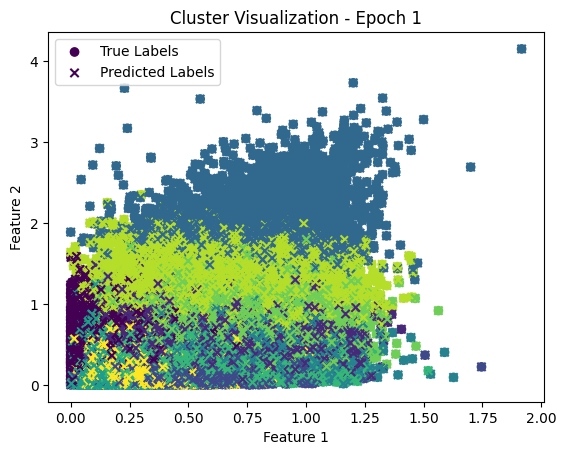

Epoch 2/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 8s 5ms/step - loss: 1.1434 - accuracy: 0.6521
Silhouette Score: 0.16518691182136536
Adjusted Rand Index (ARI): 0.9999474191576077
Normalized Mutual Information (NMI): 0.999907070123886


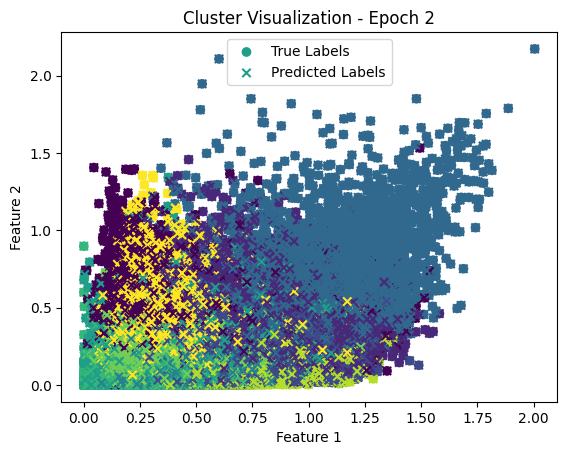

Epoch 3/3
1407/1407 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 5ms/step - loss: 1.0864 - accuracy: 0.6634
Silhouette Score: 0.1646902710199356
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


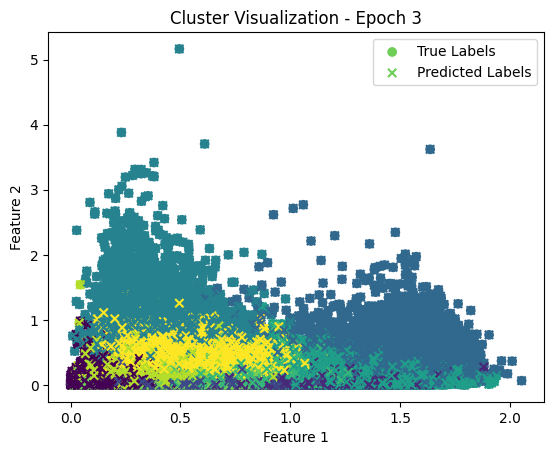

Epoch 1/3
1469/1469 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 0.9293 - accuracy: 0.7039
Silhouette Score: 0.17255240678787231
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


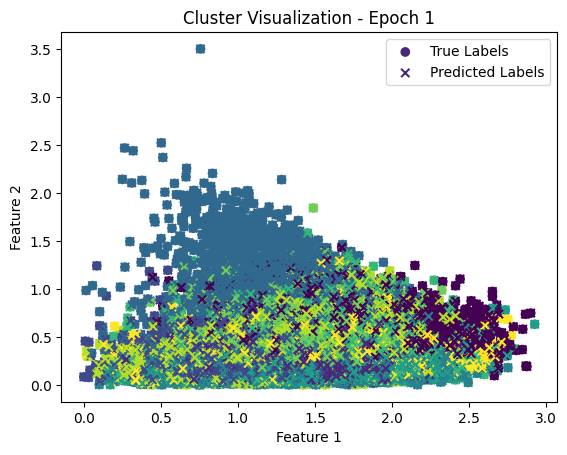

Epoch 2/3
1469/1469 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 1.0328 - accuracy: 0.6812
Silhouette Score: 0.1621679961681366
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


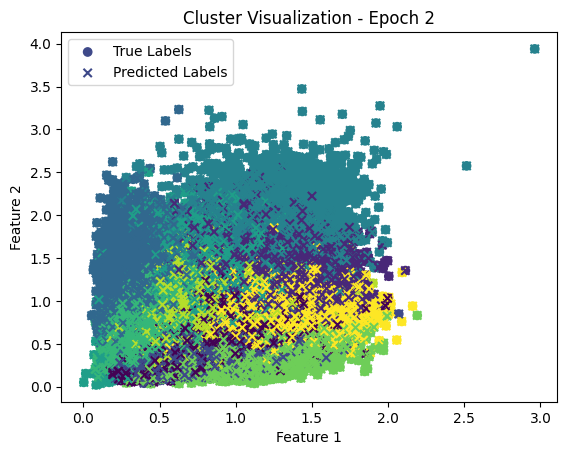

Epoch 3/3
1469/1469 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1563/1563 [==============================] - 9s 6ms/step - loss: 0.9929 - accuracy: 0.6854
Silhouette Score: 0.1741492748260498
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


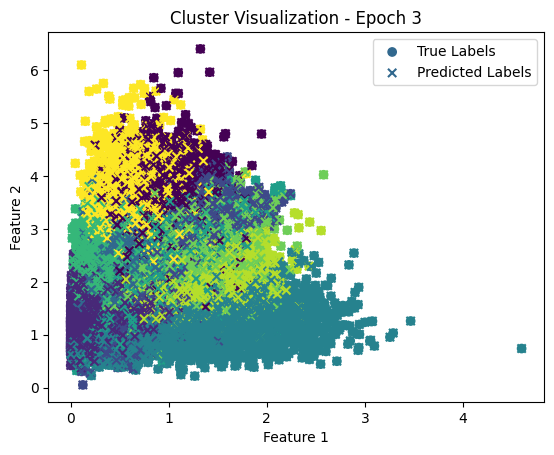

In [ ]:
M_values = [7000, 5000, 3000]
for M in M_values:
    labeled_images = train_images[:M]
    labeled_labels = train_labels_[:M]
    unlabeled_images = train_images[M:]
    resnet_model.set_weights(resnet_model.get_weights())
    weakly_supervised_training(resnet_model, labeled_images, labeled_labels, unlabeled_images, num_clusters=num_classes, epochs=3)


## Prediction for ResNet

1/1 [==============================] - 0s 19ms/step


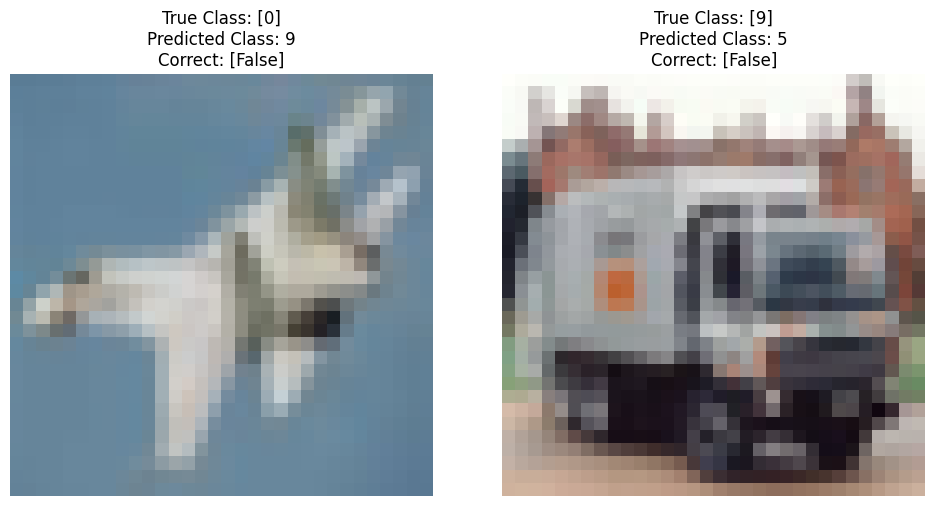

In [ ]:
display_predictions(resnet_model, test_images[10:12], test_labels[10:12])

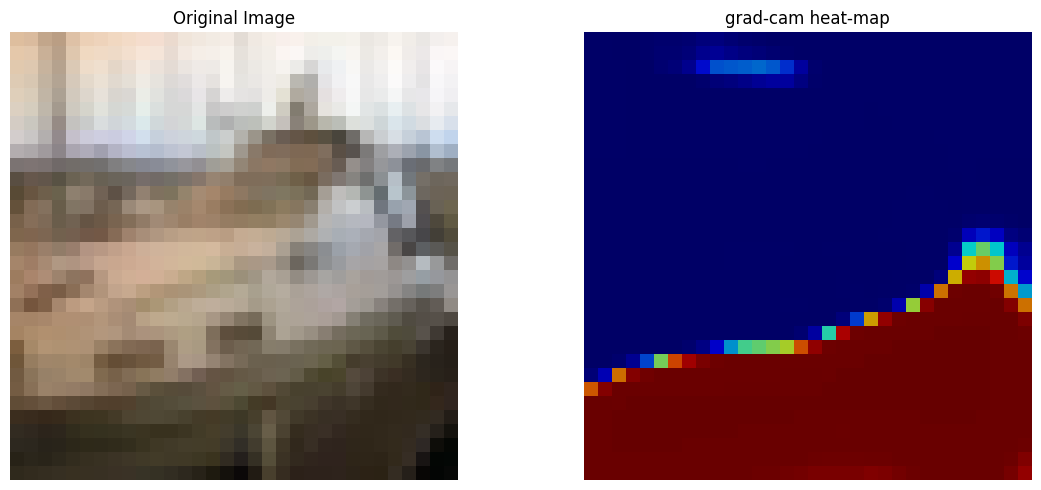

In [ ]:
img = test_images[2]
grad_cam= get_grad_cam(resnet_model,np.expand_dims(img, axis=0), 'conv2d_2')
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('grad-cam heat-map')
plt.tight_layout()

# Graphs

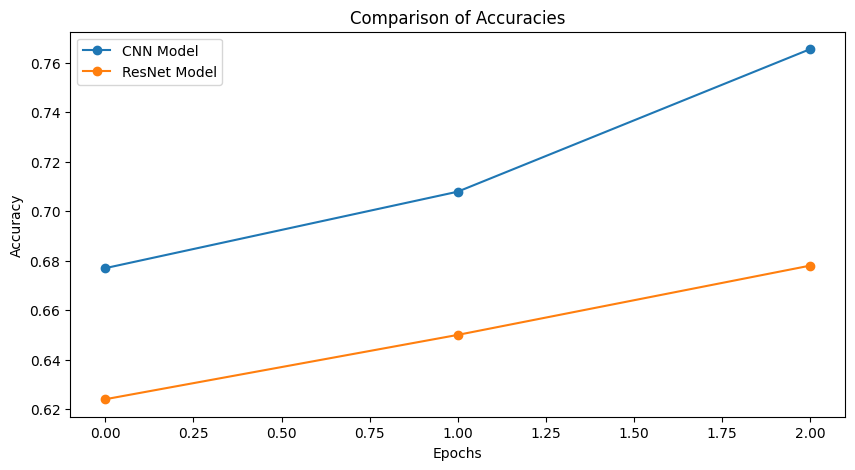

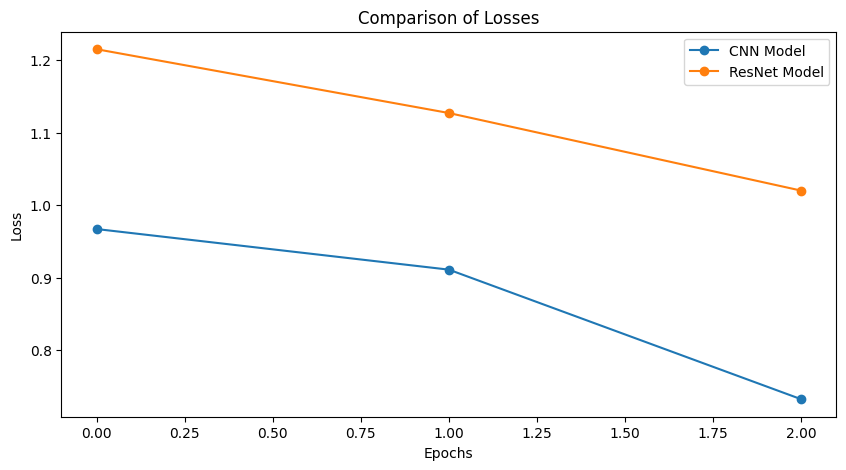

In [ ]:
# Giving the values from iterations
cnn_accuracies = [0.677,0.7079, 0.7655]
cnn_losses = [0.967,0.911,0.7323]
resnet_accuracies = [0.624, 0.65 , 0.678]
resnet_losses = [1.215, 1.127, 1.020]

# Plotting accuracies
plt.figure(figsize=(10, 5))
plt.plot(cnn_accuracies, marker='o', linestyle='-', label='CNN Model')
plt.plot(resnet_accuracies, marker='o', linestyle='-', label='ResNet Model')
plt.title('Comparison of Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(cnn_losses, marker='o', linestyle='-', label='CNN Model')
plt.plot(resnet_losses, marker='o', linestyle='-', label='ResNet Model')
plt.title('Comparison of Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



#Conclusion


This work involves using weakly supervised training using unlabeled examples from the Cifar-10 dataset. As we can observe, the performance varies with variation in M values. The two models experimented are CNN and ResNet, popular Image classification models and a simple architecture is demonstrated. As a part of Explainable AI, Gradcam is explored to find its impact in the model prediction.

The evaluation is done in terms of both classification metrics like Accuracy and in terms of visualizing the clusters. The spread is visible from the clusters.

As we have a moderate dataset with less complexity, the CNN model is able to perform better in this scenario(as shown in the graphs above). But for future work if we take more complex and larger datasets, ResNet willl be able to perform better than CNN as it has the ability to retreive the deeper features.

The performance can be improved significantly with respect to the architecture or model parameters like the activation and loss functions. The work can also be extended to applications in different domains like healthcare, environment etc. For instance, in brain tumour detection, the tumour can be highlighted in viridis map for doctors to identify and treat accordingly.